In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LassoCV
import scipy
import math
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import linear_model

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [3]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [4]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [5]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    '''
    The function is used to clean the dataframe according to user setting
    blank_keyword: part of string from column that indicates the column is a blank sample
    svb_thres: sample vs blank thres
    empty_thres: empty cell thres in a row
    cv_thres: as all sample is in triplicate, calculate the CV for every triplicate sample set #Needs to be updated in case there is no triplicate samples
    rt_range: rt filter
    mz_range: mz filter
    sn_thres: signal/noise column thres
    score_thres: score column thres
    area_thres: count for max peak area from each row
    '''
    d_thres = d_input[d_input[d_input.columns[4:]].max(1) >= area_thres]
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True, drop=True)
    
    col_blank = []
    for key in blank_keyword:
        # Get column name if it contains blank indicating strings
        col_blank.extend([col for col in d_thres.columns if key in col])
        
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    # Sample maximum area vs Blank average area to count for svb
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample] 
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    # Get a list of triplicate, every triplicate is in a sublist
    #Sample: [[a1,a2,a3],[b1,b2,b3]]
    #Note: the triplicate parsing is now only used '_' which needs update in the future
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[:-1])] 
    trip_list = [i for i in trip_list if len(i)>=2] #filter out columns that is not in triplicate -- sample naming issue

    for triplicate in tqdm(trip_list):
        # DM: maybe use iterrtuples? iterrows has low efficiency and is not reccomended 
        for row in d_sample[triplicate].itertuples(): # Loop for every sets of triplicates
            if row[1:].count(0) > empty_thres:
                d_sample.loc[row.Index, triplicate] = 0 # if more than thres, then set all three values to 0
            elif np.mean(row[1:]) != 0:
                if np.std(row[1:]) / np.mean(row[1:]) > cv_thres:
                    d_sample.loc[row.Index, triplicate] = 0 #If delete or reduce all number to avg?
            else:
                pass
            
    d_sample = d_sample[~(d_sample[d_sample.columns[4:]]==0).all(1)] #clean rows with all 0
    
    return d_sample

In [6]:
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 35/35 [01:38<00:00,  2.81s/it]


In [7]:
def ms_cluster(d_input, select_keyword, normalization='linear', visual=False, d_reduce=True, d_reduce_method='tsne', perplexity=20, cluster_method='dbscan',eps=0.8,min_samples=10):
    '''
    Function for direct clustering:
    normalization method: linear, zscore, log
    d_reduce: if perform the dimension reduction algorithm, method: only tsne is avilable now
    perplexity: parameter for tsne
    cluster_method: dbscan, later will update optic and spectrum
    eps: parameter for dbscan, threshold of radius that used to count neighbours
    min_samples: general parameter for clustering, min neighbourhoods to be counted as a cluster
    '''
    col_select = []
    for key in select_keyword:
        col_select.extend([col for col in d_input.columns if key in col])
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    #Performs normalization
    np.seterr(divide='ignore', invalid='ignore') #silent the warning -- but divide by 0 still exist
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
        else:
            pass
    #Clean up dataframe
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            d_feature = transformed.copy()
        else:
            pass
    elif d_reduce == False:
        d_feature = d_norm.copy()
    else:
        pass
    
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(d_feature)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)
        
        if visual == True:
            for i,k in enumerate(unique_labels):
                indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
                sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
                plt.title(str(cluster_method)+' label='+ str(k))
                plt.show()
        else:
            pass
        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index] #Use the index to match back to the original datasheet
        d_label.insert(4,"label", dbscan.labels_.tolist())
    elif cluster_method == 'optics':
        optics = cluster.OPTICS(min_samples=min_samples).fit(d_feature)
        labels = optics.labels_
        unique_labels = set(optics.labels_)
        if visual == True:
            for i,k in enumerate(unique_labels):
                indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
                sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
                plt.title(str(cluster_method)+' label='+ str(k))
                plt.show()
        else:
            pass
        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index] #Use the index to match back to the original datasheet
        d_label.insert(4,"label", optics.labels_.tolist())
    else:
        print('method error!')
        pass
    
    #Post filter -- filter out features that present in other sources but not SR520 -- keep it open for now
    #If activate add one more variable:source_keyword
#     col_source = []
#     for key in source_keyword:
#         col_app = [col for col in d_thres.columns if key in col]
#         col_source += col_app
#     col_rest = [col for col in d_label.columns if col not in source][5:]
#     d_label[col_app].max(1) / d_label[col_rest].max(1)
    
    return d_label

In [8]:
d_label = ms_cluster(d_sample, ['SR520-Cal'], 'linear', d_reduce=False, visual=False, cluster_method='dbscan', eps=0.6, min_samples=10)

Text(0.5, 1.0, 'clustering scatter (ambient feature excluded)')

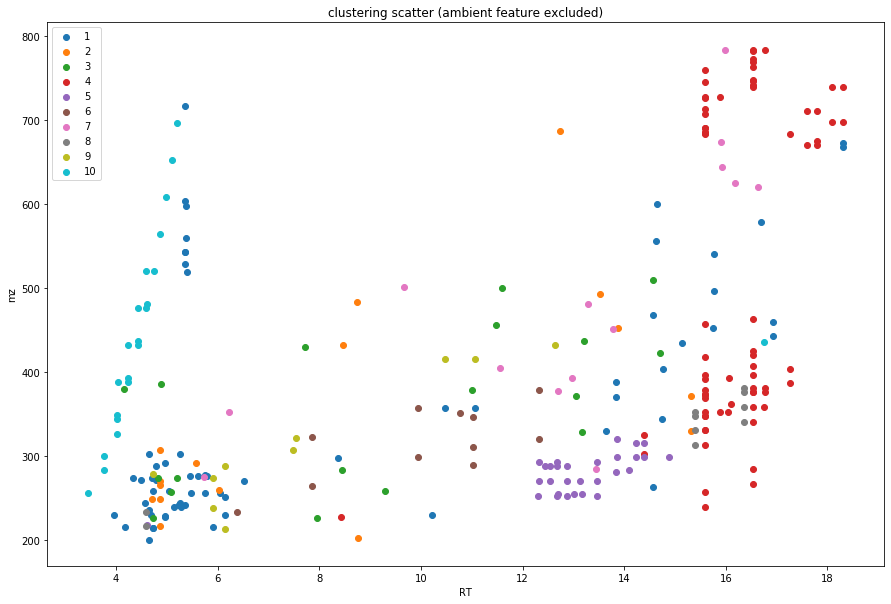

In [9]:
u_label = list(set(d_label['label']))
figure = plt.figure(figsize=(15,10))
for i in u_label:
    if i != -1 and i != 0:
        gra = d_label[d_label['label']==i]
        plt.scatter(gra['Average RT (min)'], gra['Average m/z'], label = str(i))
plt.legend()
plt.xlabel('RT')
plt.ylabel('mz')
plt.title('clustering scatter (ambient feature excluded)')

In [10]:
# options: all_data/clusters seperately
# models: multiple linear/ random forest/ etc..
# def modeling:
#     select option
#     select model
#     if option all_data:
#         model.fit(data) --> training 1114data, test 0815data
#     elif option cluster:
#         for group in cluster:
#             model.fit(group)
#         all_model -- > final_model

In [11]:
# post filtering of dilution cluster
# source tracking:
#     1. samples from different sites
#     2. vann diagram--> 'source subtraction' --> unique features for different source
#     3. use cluster/noise distinguish method --> remove noises, get clusters
#     4. source proportioning prediction 

# Trend Clustering Method 

In [12]:
def trend_calc(d_input, select_keyword, min_size=5, normalization='linear', method='pearsonr',visual=True):
    """This function calculates clustering based on the pearson correlation.
    It takes in a dataframe and a user defined value for what qualifies as a cluster.
    User can choose whether or not to have a visual plot of the scatter with True/False."""
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    #Post treatment to fit the d_norm into original codes
    d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
    d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
    d_norm = d_norm.reset_index(drop=True)
    
    
    #Original codes
    cluster = [] # individual cluster holder
    cluster_sum = [] # total clusters
    drop_list = [] # rows that are dropped from the df
    noise = [] # list for containing noise features
    while len(d_norm) > 0:
        for row in range(len(d_norm)):
            feature_1 = d_norm.iloc[0]
            feature_2 = d_norm.iloc[row]
            if method == 'pearsonr':
                corr, p_val = scipy.stats.pearsonr(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            elif method == 'mannwhitneyu':
                corr, p_val = scipy.stats.mannwhitneyu(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            elif method == 'kruskal':
                corr, p_val = scipy.stats.kruskal(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            if p_val < 0.05:
                drop_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) <= min_size:
            noise += [cluster]
            cluster = []
        else:
            cluster_sum += [cluster]
            cluster = []
        d_norm = d_norm.drop(drop_list)
        d_norm = d_norm.reset_index(drop=True)
        drop_list = []
    append_list = []
    for i in range(len(cluster_sum)):
        for j in range(len(cluster_sum[i])):
            cluster_sum[i][j].loc['Score']= i
            listing = np.array(cluster_sum[i][j])
            append_list.append(listing)
    cluster_df = pd.DataFrame(append_list) #Add columns use d_clu
    append_list2 = []
    for k in range(len(noise)):
        for l in range(len(noise[k])):
            noise[k][l].loc['Score']= -1
            listing2 = np.array(noise[k][l])
            append_list2.append(listing2)
    noise_df = pd.DataFrame(append_list2)
    final_df = pd.concat([cluster_df, noise_df])
    final_df = final_df.reset_index(drop=True)
    if visual == True:
        labels = final_df.iloc[:,-1:].values.reshape(1,-1)[0]
        unique_labels = set(labels)
        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(final_df.iloc[indexlist,2:-1].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title('trend'+'label='+ str(k))
            plt.show()
    else:
        pass
    return final_df

In [13]:
d_1=trend_calc(d_sample, ['SR520-Cal'], min_size=5, normalization='zscore', visual=False)

In [14]:
# Modeling part

In [15]:
d_test = pd.read_csv('../example_data/clustering/sample0815.csv')
d_model = d_label[d_label['label']!=-1] # 1114.csv and excludes noise here

In [16]:
def batch_alignment(d_ref, d_align, rt_error=0.5, mz_error=0.015):
    #Alignment of new dataset
    result = []
    for row in np.arange(len(d_ref)):
        #Find overlap using the error range
        overlap = np.where((d_align.iloc[:, 0] - rt_error <=
                                        d_ref.iloc[row, 0]) & (d_ref.iloc[row, 0] <=
                                        d_align.iloc[:, 0] + rt_error) & (d_align.iloc[:, 1] - mz_error <=
                                        d_ref.iloc[row, 1]) & (d_ref.iloc[row, 1] <=
                                        d_align.iloc[:, 1] + mz_error))
        if len(overlap[0]) == 1:
            result.append([overlap[0][0], row])
        elif len(overlap[0]) > 1:
            dist = []
            for i in overlap[0]: # if multiple hits, use the closer feature for alignment
                dist.append(np.sqrt(((d_align.iloc[i, 0] - d_ref.iloc[row, 0])**2) +
                                    ((d_align.iloc[i, 1] - d_ref.iloc[row, 1])**2)))
            result.append([overlap[0][np.argmin(dist)], row])
        
    #Modeling using overlapping features except noises
    align_index = [i[0] for i in result]
    ref_index = [i[1] for i in result]
    d_align = d_align.loc[align_index]
    d_ref = d_ref.iloc[ref_index]

    d_align.reset_index(drop=True,inplace=True)
    d_ref.reset_index(drop=True,inplace=True)
    d_join = d_align.iloc[:,3:] #Important !! -- The indexing is important especially reading other feedin data
    d_merge = pd.concat([d_ref,d_join],axis=1)
        
    return d_merge

In [17]:
d_merge = batch_alignment(d_model,d_test)

In [66]:
#transpose the dataframe without label column
def transpose(d_input, target_col): #This should be converted to a built-in function within the pipeline, not having a common use case
    list_label = d_merge['label']
    d_transpose = d_merge.copy()
    col_model = []
    for c_dilu in dilu_col:
        col_model.extend([col for col in d_transpose.columns if c_dilu in col])
    d_transpose = d_transpose[col_model].T
    d_transpose.reset_index(inplace=True)
    d_transpose = d_transpose.rename(columns={'index':'dilu_vol'})
    d_transpose['dilu_vol'] = d_transpose['dilu_vol'].apply(lambda x : x.replace('-','_'))
    d_transpose['dilu_vol'] = d_transpose['dilu_vol'].apply(lambda x : float(x.split('_')[-2][:-2]))
    list_insert = [-2] + list(list_label)
    df_length = len(d_transpose)
    d_transpose.loc[df_length] = list_insert
    #d_transpose.sort_values(by=d_transpose.index[-1], ascending=True, axis=1, inplace = True)
    
    return d_transpose

In [67]:
dilu_col=['SR520-Cal','SR520_Cal']
d_transpose = transpose(d_merge, dilu_col)

----------seperation--------------

In [21]:
#have the train/test split here prior to the cluster split, make the data corresponding to each other

|x1 0|x2 1|x3 0|x4 1|x5 1|y|
|---|---|---|---|---|---|
|1|2|3|5|6|dilution|
|1|2|3|5|6|dilution|
|1|2|3|5|6|dilution|
|1|2|3|5|6|dilution|
|1|2|3|5|6|dilution|
|1|2|3|5|6|dilution|
|5|5|8|10|100|unknown dilution|

cluster 0 : 1000 features

cluster 1: 1000features 

2: 1000
    
1. build models on individual clusters: model0 from cluster0 1000 features, model1 from c1 1000features
y = ax1+bx2+c
y = ax1+blog(x1)+cx1^2+dx2+ --> simplified one

2. build models iteratively: randomly pick 50 features from each of clusters, 50 * 3 = 150 features --> model1 --> repeat n times --> 

3. select representative features:  --> reduce feature numbers in each clusters
     1. exclude outliers, 25%-5/50%-10/75%-5 (intensity) features for each cluster
     2. calculate the general trend of your cluster and select features base on that

In [261]:
def feature_model(d_input, cluster_algorithm=False, test_frac=0.5, model_method='linear_reg', report=False): 
    """This function predicts the dilution of samples through two methods as that
    can be chosen by the user. The methods revolve around using all of the features
    or clustered features. It takes in two dataframes and requires the user"""
    d_transpose = d_input.copy() # avoid pandas warning
    if cluster_algorithm == True:
        # cluster separation
        cluster_index = d_transpose.iloc[-1][1:]
        d_concat_model = d_transpose.drop([d_transpose.index[-1]]) 
        # drop the index row
        xtrain, xtest, ytrain, ytest = train_test_split(d_transpose[d_transpose.columns[1:]], 
                                                        d_transpose['dilu_vol'], 
                                                        test_size=test_frac, random_state=42)
        #reattach the cluster row back for indexing
        xtrain.reset_index(inplace=True, drop=True)
        xtest.reset_index(inplace=True, drop=True)
        ytrain.reset_index(inplace=True, drop=True)
        ytest.reset_index(inplace=True, drop=True)
        xtrain.loc[len(xtrain)] = cluster_index
        xtest.loc[len(xtest)] = cluster_index
        unique_label = list(set(cluster_index)) 
        # both set should have same unique_label, so no need to replicate
        list_clusterDF = []
        list_clusterDF2 = []
        for label in unique_label:
            d_cm_label = xtrain[[i for i in xtrain.columns if xtrain.iloc[-1][i] == label]] 
            #index using the label row --update later to avoid warning
            d_cm_label.drop(d_cm_label.tail(1).index, inplace=True) 
            list_clusterDF.append(d_cm_label) 
            d_cm_label2 = xtest[[i for i in xtest.columns if xtest.iloc[-1][i] == label]] 
            d_cm_label2.drop(d_cm_label2.tail(1).index, inplace=True)
            list_clusterDF2.append(d_cm_label2) 
    else:
        # all features used for modelling
        cluster_index = d_transpose.iloc[-1]
        d_concat_model = d_transpose.drop([d_transpose.index[-1]])
        xtrain, xtest, ytrain, ytest = train_test_split(d_transpose[d_transpose.columns[1:]], 
                                                        d_transpose['dilu_vol'], 
                                                        test_size=0.5, random_state=42)
    print('data split finished!')
    if model_method == 'linear_reg':
        slope = []
        intercept = []
        scores = []
        if cluster_algorithm == True:
            reg_list = []
            for i in range(len(list_clusterDF)):
                model = linear_model.LinearRegression()
                reg = model.fit(list_clusterDF[i], ytrain)
                reg.predict(list_clusterDF2[i])
                scores.append(reg.score(list_clusterDF2[i], ytest))
                slope.append(reg.coef_)
                intercept.append(reg.intercept_)
                reg_list.append(reg)
        else:
            model = linear_model.LinearRegression()
            reg = model.fit(xtrain, ytrain)
            reg.predict(xtest)
            slope.append(reg.coef_)
            intercept.append(reg.intercept_)
    
    # For all below modelings, in later dev should either have a reasonable default param, 
    # or leave space in function for user to define params
    elif model_method == 'ensemble_rf':
        features = 5 #this number needs to be smaller than the X numbers otherwise will raise error
        seed = 10
        if cluster_algorithm == True:
            reg_list = []
            scores = []
            for i in range(len(list_clusterDF)):
                model = RandomForestRegressor(n_estimators=1000, max_features=features, random_state=seed)
                reg = model.fit(list_clusterDF[i], ytrain)
                scores.append(reg.score(list_clusterDF2[i], ytest))
                reg.predict(list_clusterDF2[i])
                reg_list.append(reg)
        else:
            model = RandomForestRegressor(n_estimators=1000, max_features=features, random_state=seed)
            reg = model.fit(xtrain, ytrain)
            reg.predict(xtest)    
    elif model_method == 'ensemble_bagging_dt':
        scores = []
        num_trees = 5
        seed = 10
        if cluster_algorithm == True:
            reg_list = []
            for i in range(len(list_clusterDF)):
                model = BaggingRegressor(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=seed)
                reg = model.fit(list_clusterDF[i], ytrain)
                scores.append(reg.score(list_clusterDF2[i], ytest))
                reg.predict(list_clusterDF2[i])
                reg_list.append(reg)
        else:
            model = BaggingRegressor(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=seed)
            reg = model.fit(xtrain, ytrain)
            reg.predict(xtest)
            
    elif model_method == 'ensemble_bagging_svc':
        scores = []
        num_trees = 5
        seed=10
        if cluster_algorithm == True:
            reg_list = []
            for i in range(len(list_clusterDF)):
                model = BaggingRegressor(base_estimator=SVC(), n_estimators=num_trees, random_state=seed)
                reg = model.fit(list_clusterDF[i], ytrain)
                scores.append(reg.score(list_clusterDF2[i], ytest))
                reg.predict(list_clusterDF2[i])
                reg_list.append(reg)
        else:
            model = BaggingRegressor(base_estimator=SVC(), n_estimators=num_trees, random_state=seed)
            reg = model.fit(xtrain, ytrain)
            reg.predict(xtest)
            
    else:
        print('please define a valid model!')
        pass
    print('modeling finished!')
    
    if report == True:
        print('Report starting...')
        if cluster_algorithm == True: 
            reg = reg_list
            if model_method == 'linear_reg':
                print(reg[0])
                for value in range(len(slope)):
                    slope_val = slope[value]
                    intercept_val = intercept[value]
                    score_val = scores[value]
                    print('The slope for cluster', value, 'is:', slope_val)
                    print('The intercept for cluster', value, 'is:', intercept_val)
                    print('The model score for cluster', value, 'is:', score_val)
                print('Note the model score reflects coefficient of determination.')
                print('Report finished!')
            else:
                print(reg[0])
                for value in range(len(scores)):
                    score_val = scores[value]
                    print('The model score for cluster', value, 'is:', score_val)
                print('The model score reflects the mean accuracy.')
                print('Report finished!')
                pass
        else:
            if model_method == 'linear_reg':
                plt.plot(ytest, reg.predict(xtest))
                plt.xlabel('Actual dilution (mL)')
                plt.ylabel('Predicted dilution (mL)')
                print('The model score is:' ,'%.3f' % reg.score(xtest, ytest))
                print('The model score reflects the coefficient of determination.')
                print('The predicted slope is:', score, 'and intercept is:', intercept[0])
                print('Report finished!')
            else:
                plt.plot(ytest, reg.predict(xtest))
                plt.xlabel('Actual dilution (mL)')
                plt.ylabel('Predicted dilution (mL)')
                print('The model score is:' ,'%.3f' % reg.score(xtest, ytest))
                print('The model score reflects the mean accuracy.')
                print('Report finished!')
    else:
        pass
    
    if cluster_algorithm == True:
        reg = reg_list
    else:
        pass
    
    return reg

In [267]:
reg3 = feature_model(d_transpose, cluster_algorithm=True, model_method='ensemble_bagging_svc', report=False)

D:\python\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


data split finished!
modeling finished!


For all feature modeling, as the output already a model, just fit using model.predict() should work

In [264]:
def cluster_pred(model_list, d_merge, col_name, selected_cluster, model_merge='weighted_size',confidence=0.95): #The function only works with cluster==True in dilu_predict
    '''The selected_cluster will be user based according to score report from feature_model function'''
    input_label = sorted(selected_cluster)
    unique_label = list(set(d_merge['label']))
    idx = [i for i, label in enumerate(unique_label) if label in input_label] #get position for input labels
    model_list = [model_list[i] for i in idx] #slice model list according to index
    
    if len(model_list) != len(input_label):
        print("model didn't match labels!")
    else:
        pass
    
    pred_list = []
    for i in np.arange(len(model_list)):
        pred_list.extend(model_list[i].predict(np.asarray(d_merge[d_merge['label'] == input_label[i]][col_name]).reshape(1,-1)))
    
    def mean_confidence_interval(data, confidence):
        a = 1.0 * np.array(data)
        n = len(a)
        se = scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return h
    
    if model_merge == 'weighted_size':
        size_list = []
        for i in input_label:
            size_list.append(d_merge[d_merge['label'] == i].shape[0])
        weight_list = [i/sum(size_list) for i in size_list]
        pred = sum([p * w for p, w in zip(pred_list, weight_list)])
        #Leave the CI part out for now..
        #ci = mean_confidence_interval(pred_list, confidence=confidence)
    elif model_merge == 'average':
        pred = np.mean(pred_list)
        #ci = mean_confidence_interval(pred_list, confidence=confidence)
        
    return pred

In [268]:
cluster_pred(reg3, d_merge, '20181114_CoulterCreek_1', selected_cluster=[0,1,3,5,7,9], model_merge='weighted_size')

22.061519302615192

# Small data solution:
1. use simple model -- OLS, rf/dt
2. emsemble method -- combine models from different clusters
    1. for instance, seperately build model on n clusters and combine the prediction result at the end
    2. further, do the iterative modeling -- take n features out from each cluster, build model, merge result, repeat the process
3. use less features for modeling -- only use the features that is representative for the clusters

this is especially useful in our case as most of the features within the same cluster should have strong collinearity
    
    strategy to reduce features in clusters:
    0. before reduction, need to verify the cluster is correctly seperated
    1. select features most close to the average (normalized average)
    2. select features at lower/upper/25%/50%/75% boundaries
    3. select features with highest intensity/lowest intensity
    
<font color = 'red'>4. get confidence interval rather than only a solid prediction result
